In [208]:
%matplotlib inline

# to set the path for importing HADES modules
import sys
sys.path.append("../source")


from hades_input import hades_input
from hades_location import hades_location

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from hades_rotation import Cluster
import rotations_utils  as ru

from scipy.spatial.transform import Rotation as R
from rotations_utils import define_axis_vectors
from LatLongUTMconversion import LLtoUTM, UTMtoLL
from hades_utils import sortout

In [209]:
def z_quat(theta, v0):
  """Takes the first angle theta and computes the quaternion around axis v0."""

  v0 = v0

  r_a = R.from_quat([v0[0] * np.sin(theta/2),     # compute quaternions
                              v0[1] * np.sin(theta/2), 
                              v0[2] * np.sin(theta/2), 
                              np.cos(theta/2) ])

  return r_a


def a_quat(theta, v1):
    """Takes the second angle theta and computes the quaternion around axis v0."""

    v1 = v1

    r_b = R.from_quat([v1[0] * np.sin(theta/2),     # compute quaternions
                                v1[1] * np.sin(theta/2), 
                                v1[2] * np.sin(theta/2), 
                                np.cos(theta/2) ])

    return r_b


def b_quat(theta, v2):

    v2 = v2

    r_c = R.from_quat([v2[0] * np.sin(theta/2),     # compute quaternions
                                v2[1] * np.sin(theta/2), 
                                v2[2] * np.sin(theta/2), 
                                np.cos(theta/2) ])

    return r_c
def invert_rotations_spatial(cluster, rotations, station, bary):
    """
    Inverts the rotation
    """

    bary = bary
    v0, v1, v2 = define_axis_vectors(station, bary)

    ca = b_quat(np.radians(rotations[2]), v2).inv().apply(cluster - bary) 
    cb = a_quat(np.radians(rotations[1]), v1).inv().apply(ca ) 
    cF = z_quat(np.radians(rotations[0]), v0).inv().apply(cb ) + bary
    
    

    return cF



'Location process completed, number of located events: 320 '

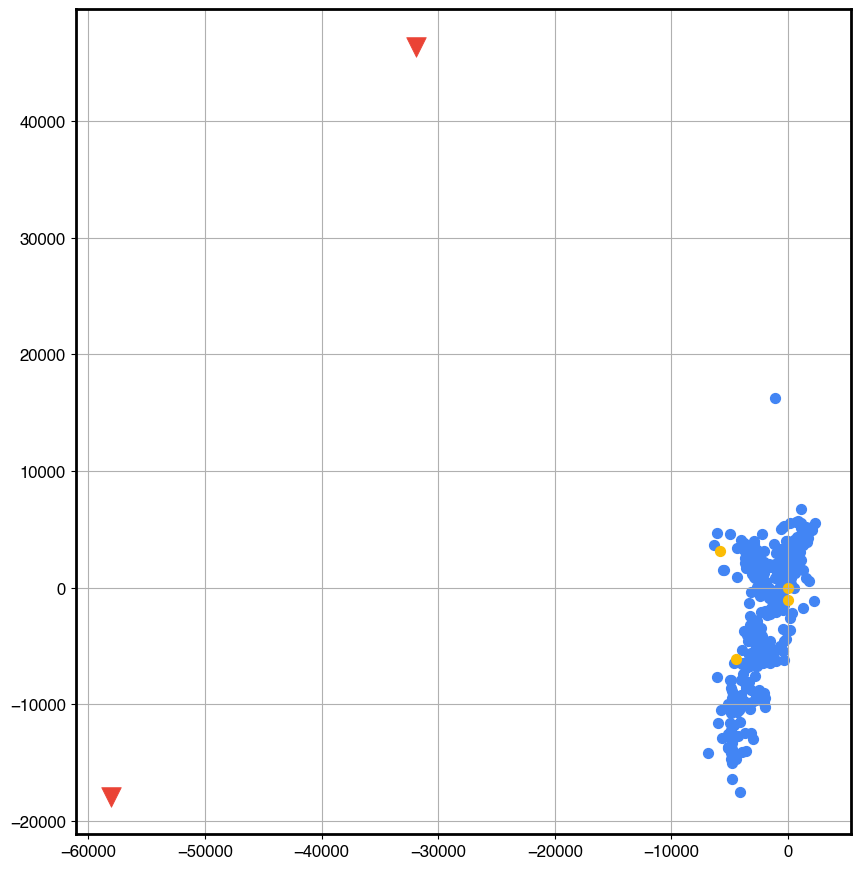

In [210]:
hypoDD_locs = np.loadtxt('./data/inputs/hypoDD_locs_ridge.csv', delimiter=';')


# Create an input object with data loaded 
data_path = './data/'                            
input_file_4 = 'inputs/ridgecrest_gji_4.dat'       # This contains the event times and arrival time picks
station_file = 'inputs/stations_ridge.txt'     # This contains the station locations

# Homogeneous velocity estimates for the Ridgecrest example
Vp = 6000
Vs = Vp/1.73

# Stations: pick one or preferably two stations out of your station list. In this case
# we only have two stations, so that is easy
stations = ['WBS', 'WMF']

hobj_1 = hades_input(
    data_path = data_path,          # the general path to the data
    event_file = input_file_4,        # the input event file path
    station_file = station_file,    # the station file path
    sta_select = stations           # your two stations
)

# And think of a filename to deposit our results in
out_file = 'ridgecrest_twostations_1'

hobj_1.relative_frame(Vp,Vs,stations,y_ref=-1,z_ref=1,fixed_depth=8)
hobj_1.distance_calculation(Vp,Vs,stations)
hloc_1=hades_location(input_obj=hobj_1, output_path='./data/outputs/', output_frame='cart')
hloc_1.location(out_file, mode='rel', plot=True)

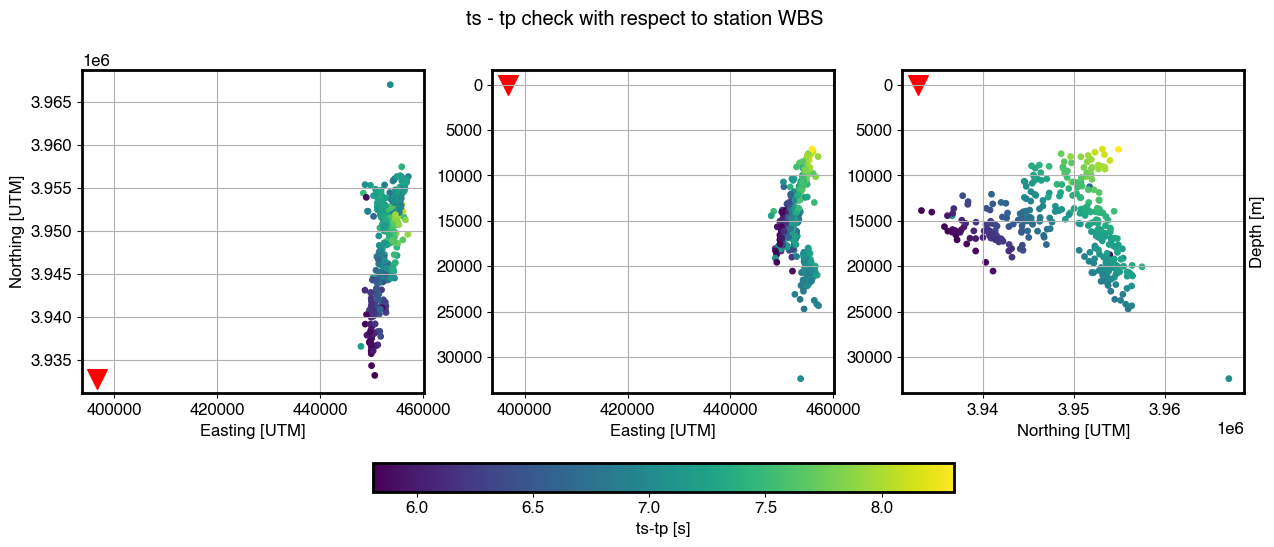

In [211]:
# Let's take a closer look
origin = hloc_1.input.origin

origin_UTM = np.array(LLtoUTM(23, origin[0], origin[1])[1:])

locs_1 = hloc_1.locations.copy()
locs_1[:,0] = locs_1[:,0] + origin_UTM[0]
locs_1[:,1] = locs_1[:,1] + origin_UTM[1]


#### Which results do you want to take a closer look at? ##################
look = sortout(locs_1, np.array([0,3,6,8])+1)                           # locs_15, locs_8, locs_4, locs_1
stations = hobj_1.stations.copy()       # hobj_15, hobj_8, hobj_4, hobj_1 
stat_choice = 'WBS' # 'WBS' or 'WMF'
###########################################################################



#------------------------------------------------------------------------------------------------#
evtsps = np.array(hloc_1.evtsps.copy()[stat_choice])

fig, ax = plt.subplots(1,3, figsize=(15,6))

ax[0].grid()
ax[0].scatter(look[:,0], look[:,1], s=15, c=evtsps, cmap='viridis')
ax[0].scatter(stations[stat_choice][0]+origin_UTM[0], stations[stat_choice][1]+origin_UTM[1],
                marker='v', s=200, c='r')
ax[0].set_xlabel('Easting [UTM]')
ax[0].set_ylabel('Northing [UTM]')


ax[1].grid()
ax[1].scatter(look[:,0], look[:,2], s=15, c=evtsps, cmap='viridis')
ax[1].scatter(stations[stat_choice][0]+origin_UTM[0], stations[stat_choice][2],
                marker='v', s=200, c='r')
ax[1].invert_yaxis()
ax[1].set_xlabel('Easting [UTM]')

ax[2].grid()
im=ax[2].scatter(look[:,1], look[:,2], s=15, c=evtsps, cmap='viridis')
ax[2].scatter(stations[stat_choice][1]+origin_UTM[1], stations[stat_choice][2],
                marker='v', s=200, c='r')
ax[2].invert_yaxis()
ax[2].set_xlabel('Northing [UTM]')
ax[2].set_ylabel('Depth [m]')
ax[2].yaxis.set_label_position('right')

plt.colorbar(im, ax=ax[:], shrink=.5, label='ts-tp [s]', orientation='horizontal')
plt.suptitle(f'ts - tp check with respect to station {stat_choice}')

# plt.tight_layout()
plt.show()

In [212]:
axis = 1

stations = hobj_1.stations

locs_1 = sortout(locs_1, np.array([0,3,6,8])+1)   
stats = np.array([
    [stations['WBS'][0]+origin_UTM[0], stations['WBS'][1]+origin_UTM[1], stations['WBS'][2]], 
    [stations['WMF'][0]+origin_UTM[0], stations['WMF'][1]+origin_UTM[1], stations['WMF'][2]]
    ])

# locs_1[:,0] = locs_1[:,0] + origin_UTM[0]
# locs_1[:,1] = locs_1[:,1] + origin_UTM[1]

bary, v0, v1, v2, cluster_opt, dtps_obs, stavect = ru.setup(optall=True, master_evts=np.array([0,3,6,8]),cluster=None, dtps_obs=np.array([hloc_1.evtsps.copy()['WBS'], np.array(hloc_1.evtsps.copy()['WMF'])]), 
                cluster_rot=locs_1, stations=stats, station_axis=axis, vs=Vs, vp=Vp, baryp=locs_1[0,:])

#------------------------#
Your choices:
#------------------------#
Station [ 422819.98177026 3997198.73515102       0.        ] chosen as axis station
Optall = True, use all cluster events for rotation finder


In [213]:
instance_cluster = Cluster(cluster=locs_1, axis=axis, stations=stats,
            bary=bary, subcluster=locs_1, vs=Vs, vp=Vp, dtps_org=np.array([hloc_1.evtsps.copy()['WBS'], np.array(hloc_1.evtsps.copy()['WMF'])]), cluster_true=hypoDD_locs)

BEST PARAMETERS
      fun: 8.578829420055131
     jac: array([ 1.95399097e-06, -3.55271086e-07, -1.24345057e-06])
 message: 'Optimization terminated successfully.'
    nfev: 2282
     nit: 49
 success: True
       x: array([145.58219031, 140.12976401,  83.01783601])
thetas [145.58219031 140.12976401  83.01783601]


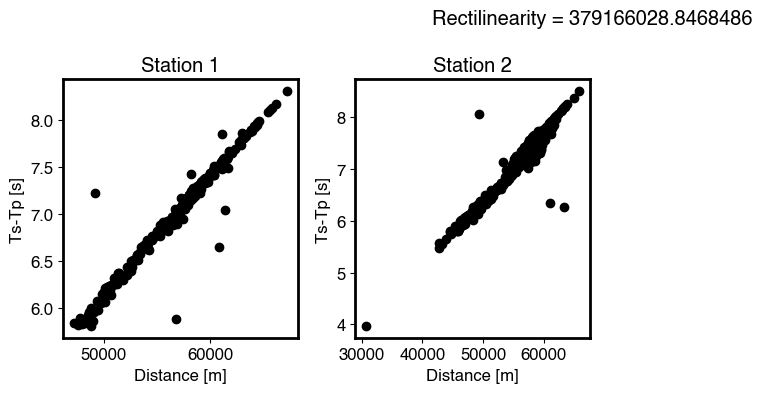

[145.58219031 140.12976401  83.01783601]


---------------------------------------
Final rectilinearity: 379166028.8468486
---------------------------------------




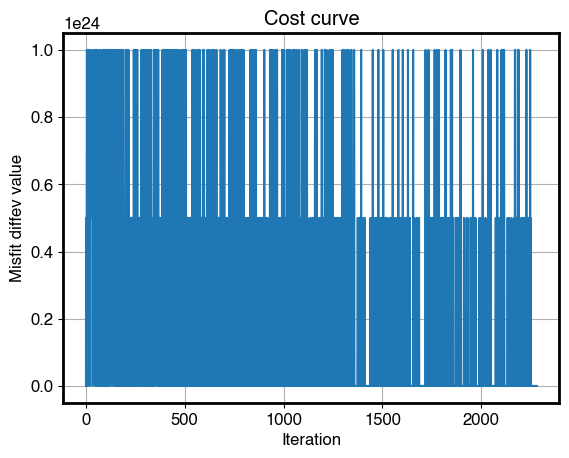

In [214]:
test_thetas = instance_cluster.optimize_rotations(prior=[0.,0.,0.], method='diffev', optall=True)

In [215]:
cluster_comp = instance_cluster.invert_rotations_spatial(locs_1, test_thetas)

In [216]:
mpl.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 2

plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.labelsize'] = 12


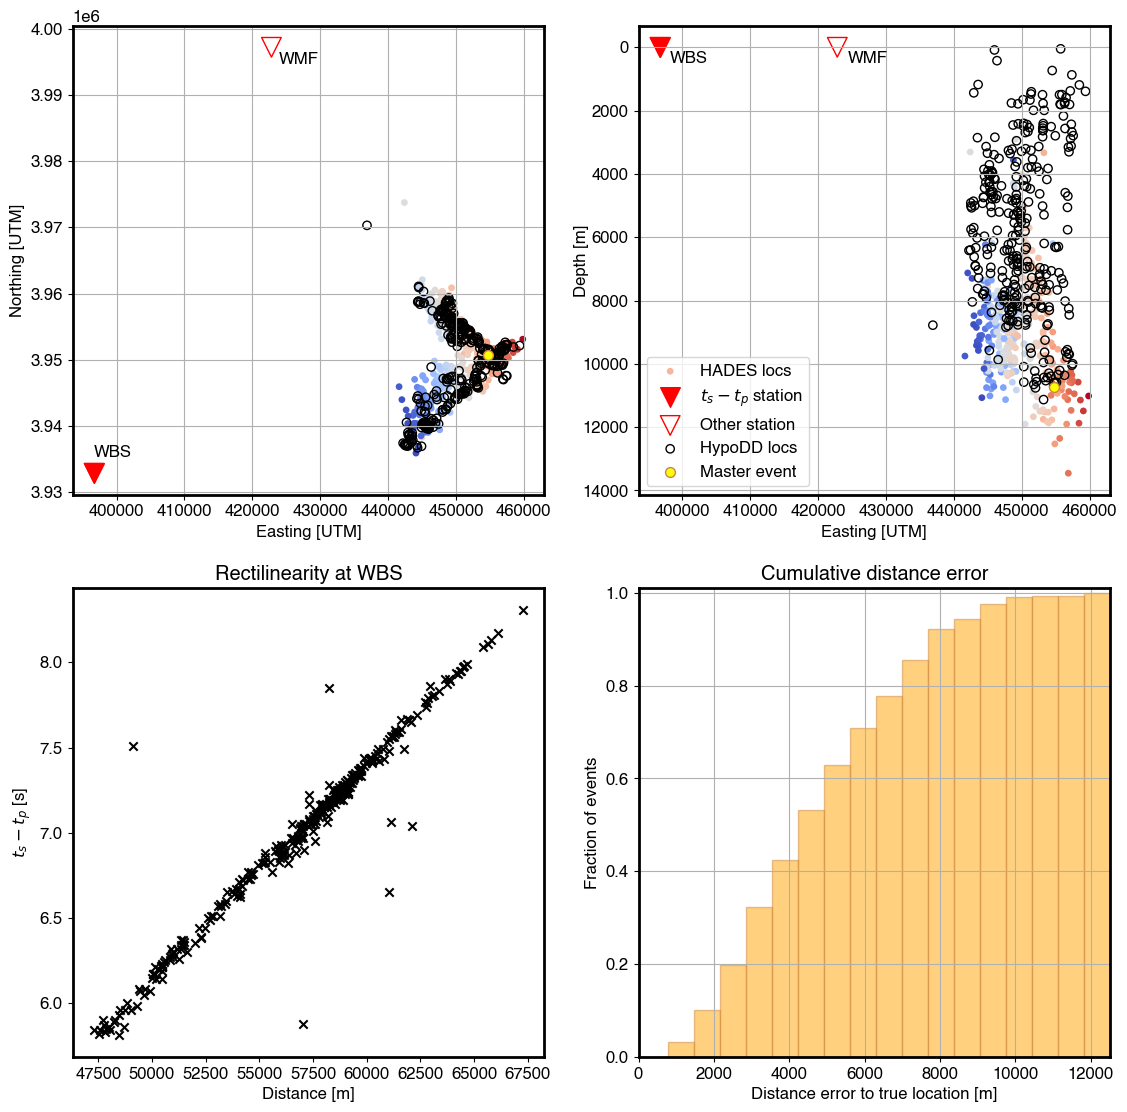

In [217]:
# Let's take a closer look

#### Which results do you want to take a closer look at? ##################
# look = locs_1                           # locs_15, locs_8, locs_4, locs_1
stations = hobj_1.stations.copy()       # hobj_15, hobj_8, hobj_4, hobj_1 
stat_choice = 'WBS' # 'WBS' or 'WMF'
###########################################################################



#------------------------------------------------------------------------------------------------#
evtsps = np.array(hloc_1.evtsps.copy()[stat_choice])
cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(2,2, figsize=(17*cm*2,17*cm*2))

ax[0,0].grid()
ax[0,0].scatter(cluster_comp[:,0], cluster_comp[:,1], s=15, c=evtsps, cmap='coolwarm', label='HADES locations')
ax[0,0].scatter(stations[stat_choice][0]+origin_UTM[0], stations[stat_choice][1]+origin_UTM[1],
                marker='v', s=200, c='r')
ax[0,0].scatter(stations['WBS'][0]+origin_UTM[0], stations['WBS'][1]+origin_UTM[1],
                marker='v', s=200, edgecolor='r', facecolor='None')
ax[0,0].annotate('WBS', (stations['WBS'][0]+origin_UTM[0], stations['WBS'][1]+origin_UTM[1]+2500))
ax[0,0].scatter(stations['WMF'][0]+origin_UTM[0], stations['WMF'][1]+origin_UTM[1],
                marker='v', s=200, edgecolor='r', facecolor='None')
ax[0,0].annotate('WMF', (stations['WMF'][0]+origin_UTM[0]+1000, stations['WMF'][1]+origin_UTM[1]-2500))
ax[0,0].scatter(hypoDD_locs[:,0], hypoDD_locs[:,1], label='HypoDD', facecolor='None', edgecolor='k')
ax[0,0].scatter(bary[0], bary[1], s=50, facecolor='yellow', edgecolor='Peru', label='Master event')

ax[0,0].set_xlabel('Easting [UTM]')
ax[0,0].set_ylabel('Northing [UTM]')


ax[0,1].grid()
ax[0,1].scatter(cluster_comp[:,0], cluster_comp[:,2], s=15, c=evtsps, cmap='coolwarm', label='HADES locs')
ax[0,1].scatter(stations[stat_choice][0]+origin_UTM[0], stations[stat_choice][2],
                marker='v', s=200, c='r', label='$t_s-t_p$ station')
ax[0,1].annotate('WBS', (stations['WBS'][0]+origin_UTM[0]+1500, stations['WBS'][2]+500))
ax[0,1].scatter(stations['WBS'][0]+origin_UTM[0], stations['WBS'][2],
                marker='v', s=200, edgecolor='r', facecolor='None', label='Other station')
ax[0,1].scatter(stations['WMF'][0]+origin_UTM[0], stations['WMF'][2],
                marker='v', s=200, edgecolor='r', facecolor='None')
ax[0,1].annotate('WMF', (stations['WMF'][0]+origin_UTM[0]+1500, stations['WMF'][2]+500))
ax[0,1].scatter(hypoDD_locs[:,0], hypoDD_locs[:,2], label='HypoDD locs', facecolor='None', edgecolor='k')
ax[0,1].scatter(bary[0], bary[2], s=50, facecolor='yellow', edgecolor='Peru', label='Master event')
ax[0,1].legend(loc='lower left')
ax[0,1].invert_yaxis()
ax[0,1].set_ylabel('Depth [m]', labelpad=-5)
ax[0,1].set_xlabel('Easting [UTM]')

ax[1,0].set_title('Rectilinearity at WBS')
ax[1,0].set_xlabel('Distance [m]')
ax[1,0].set_ylabel('$t_s - t_p$ [s]')
ax[1,0].scatter(xs[0], ys[0], marker='x', c='k')
# ax[1,0].grid()
# im=ax[1,0].scatter(cluster_comp[:,1], cluster_comp[:,2], s=15, c=evtsps, cmap='coolwarm')
# ax[1,0].scatter(stations[stat_choice][1]+origin_UTM[1], stations[stat_choice][2],
#                 marker='v', s=200, c='r')
# ax[1,0].scatter(stations['WBS'][1]+origin_UTM[1], stations['WBS'][2],
#                 marker='v', s=200, edgecolor='r', facecolor='None')
# ax[1,0].scatter(stations['WMF'][1]+origin_UTM[1], stations['WMF'][2],
#                 marker='v', s=200, edgecolor='r', facecolor='None')
# ax[1,0].scatter(hypoDD_locs[:,1], hypoDD_locs[:,2], label='HypoDD', facecolor='None', edgecolor='k')
# ax[1,0].scatter(bary[1], bary[2], s=50, facecolor='yellow', edgecolor='Peru')
# ax[2].scatter(cluster_comp[ma])

# ax[1,0].invert_yaxis()
# ax[1,0].set_xlabel('Northing [UTM]')
# ax[1,0].set_ylabel('Depth [m]', labelpad=-5)
# ax[1,0].yaxis.set_label_position('left')
# _,_,ax[1,0]= pca_theta_calculation(stats,
#     np.array([hloc_1.evtsps.copy()['WBS'], np.array(hloc_1.evtsps.copy()['WMF'])]).T, cluster_comp, plot=True)

ax[1,1].grid()
ax[1,1].set_title('Cumulative distance error')
n, bins2, patches = ax[1,1].hist(np.sort(distance), bins=int(np.sqrt(len(distance))),cumulative=True, density=True, facecolor='orange', edgecolor='Peru', alpha=.5)
ax[1,1].set_xlabel('Distance error to true location [m]')
ax[1,1].set_ylabel('Fraction of events')
ax[1,1].set_xlim(0,distance.max())
ax[1,1].set_ylim(0,1.01)
# fig.savefig('./images_geo/cumulative_error_synthetic.png', dpi=300)
plt.show()

fig.colorbar(im, ax=ax[0,1], shrink=.5, label='$t_s-t_p$ [s]', orientation='horizontal')
# fig.suptitle(f'$t_s - t_p$ check with respect to station {stat_choice}')
# plt.tight_layout()
fig.savefig('./data/images/ridge_rotated_auto_YAY.png', dpi=300)
plt.show()

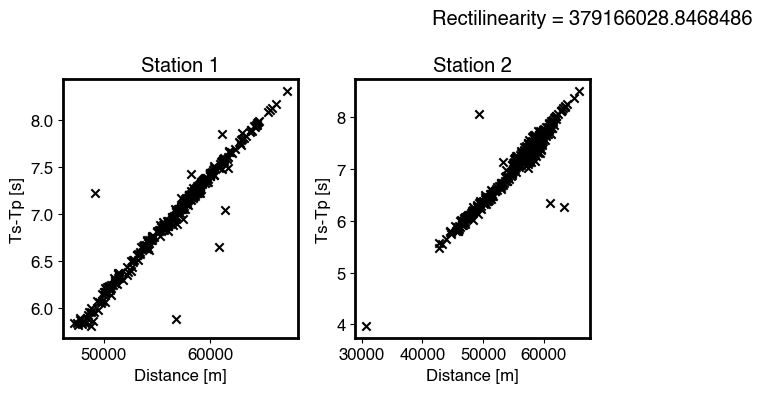

In [218]:
# fig =plt.subplots()

_,figp, axp,xs,ys = pca_theta_calculation(stats,
    np.array([hloc_1.evtsps.copy()['WBS'], np.array(hloc_1.evtsps.copy()['WMF'])]).T, cluster_comp, plot=True)


In [219]:
def pca_theta_calculation(stations, evtsps, c_try, plot=False):

        xobs, yobs, zobs = c_try[:,0], c_try[:,1], c_try[:,2]
        stations = stations

        rect=1
        signs=[]
        rectall=[]
        count = 1 
        xs, ys = [], []
        if plot==True:
            fig=plt.figure(figsize=(12,4))

        for sta in range(len(stations[:,0])):
            X=np.zeros([np.size(xobs),2])
            dx=(xobs-stations[sta,0])
            dy=(yobs-stations[sta,1])
            dz=(zobs-stations[sta,2])
            tsp=np.array(evtsps[:,sta])
            dist=np.sqrt(dx**2+dy**2+dz**2)
            ir_dist=np.argsort(dist)
            X[:,0]=dist[ir_dist]
            X[:,1]=tsp[ir_dist]
            M=np.mean(X.T, axis=1)
            C=X-M
            V=np.cov(C.T)
            values, vectors = np.linalg.eigh(V)
            sign=np.sign(vectors[0,1]*vectors[1,1])
            signs.append(1*sign)

            rect= 1e18/(rect*(np.max(values)/(np.min(values)+1e-30)))


            if plot==True:          
                ax1 = plt.subplot(1,4,count)
                plt.title(f'Station {count}')
                plt.xlabel('Distance [m]'), plt.ylabel('Ts-Tp [s]')
                ax1.scatter(dist[ir_dist], tsp[ir_dist], marker='x', c='k')
                xs.append(dist[ir_dist])
                ys.append(tsp[ir_dist])
            count += 1

            if signs[sta]>=0:
                rect=rect
            else:
                rect=1e24#-1*rect

            rectall.append(rect)

        if plot==True:
            fig.suptitle(f'Rectilinearity = {np.mean(np.array(rectall))}')
            fig.tight_layout()
            plt.show()

        return np.mean(np.array(rectall)), fig, ax1, xs[:len(c_try)], ys[:len(c_try)]

In [220]:
xs[0]

array([47229.11152944, 47522.5777179 , 47625.1021901 , 47801.16515611,
       47824.0335745 , 47990.28449998, 47991.81832747, 48141.45381256,
       48227.24828795, 48418.14402301, 48446.03293859, 48574.3803627 ,
       48584.61194209, 48792.26162242, 48857.0495777 , 48862.50728781,
       48969.43701571, 49065.35684631, 49181.27409851, 49427.85259175,
       49499.69222144, 49531.85440447, 49761.52244627, 49822.14078897,
       49893.65060994, 50013.84350831, 50017.53765344, 50072.90921972,
       50103.93815458, 50126.97375867, 50157.44014087, 50190.70329388,
       50243.64066412, 50357.03437727, 50410.15986293, 50465.95642683,
       50480.12040516, 50495.17645083, 50496.73972506, 50567.17369784,
       50617.859313  , 50718.19392305, 50726.51735251, 50908.37714712,
       51012.41828117, 51031.50798177, 51040.49443515, 51041.32760574,
       51073.04463448, 51242.64222419, 51315.00042342, 51318.04292285,
       51361.42439867, 51410.17443826, 51447.32419928, 51479.15355759,
      

In [221]:
np.savetxt('./data/outputs/ridgecrest/ridgecrest_autorot_result.csv', cluster_comp,delimiter=';')
np.savetxt('./data/outputs/ridgecrest/master_evt.csv', bary, delimiter=';')
np.savetxt('./data/outputs/ridgecrest/evtsps.csv', evtsps, delimiter=';')


In [222]:
distance = np.zeros(len(cluster_comp))
n_evs = len(cluster_comp)
for i in range(n_evs):
        distance[i] = np.sqrt((cluster_comp[i,0]-hypoDD_locs[i,0])**2 +
                        (cluster_comp[i,1]-hypoDD_locs[i,1])**2 +
                        (cluster_comp[i,2]-hypoDD_locs[i,2])**2 )

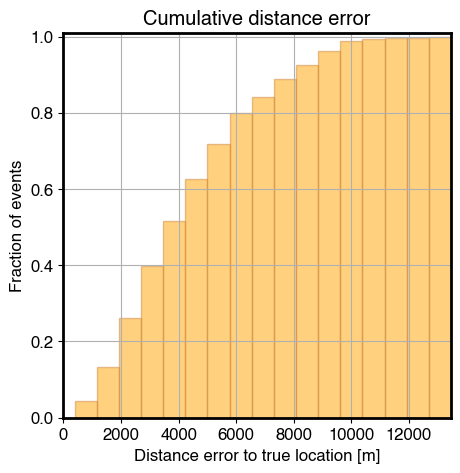

In [223]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5,5))

ax.grid()
ax.set_title('Cumulative distance error')
n, bins2, patches = ax.hist(np.sort(distance), bins=int(np.sqrt(len(distance))),cumulative=True, density=True, facecolor='orange', edgecolor='Peru', alpha=.5)
ax.set_xlabel('Distance error to true location [m]')
ax.set_ylabel('Fraction of events')
ax.set_xlim(0,distance.max())
ax.set_ylim(0,1.01)
# fig.savefig('./images_geo/cumulative_error_synthetic.png', dpi=300)
plt.show()